<a href="https://colab.research.google.com/github/Khuspd121/fluffy-spork-emotion-curated-content-/blob/main/Emotion_Detection_Model_Training.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Installing packages

In [1]:
!pip install tensorflow opencv-python numpy pandas flask flask-cors

Main file for training emotion detection model

In [1]:
import os
import sys

# --- Colab Setup (Run these cells first if using Google Colab) ---
# This section handles connecting to Kaggle and downloading the dataset directly.
# If running locally, you can skip this and just place the 'fer2013' folder
# in the same directory as this script.

def setup_kaggle_and_download():
    """Sets up Kaggle API and downloads the FER-2013 dataset."""
    # Check if running in Colab
    if 'google.colab' not in sys.modules:
        print("Not running in Colab. Skipping Kaggle setup.")
        return

    print("Setting up Kaggle API...")
    # Install the Kaggle library
    !pip install -q kaggle

    # Prompt user to upload their kaggle.json file
    from google.colab import files
    print("Please upload your 'kaggle.json' file from your computer.")
    uploaded = files.upload()

    # Check if the file was uploaded
    if "kaggle.json" not in uploaded:
        print("\n❌ Error: 'kaggle.json' not uploaded. Please run this cell again.")
        return

    # Move the kaggle.json file to the required directory and set permissions
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("✅ Kaggle API configured successfully.")

    # Download the dataset
    print("\nDownloading FER-2013 dataset from Kaggle...")
    !kaggle datasets download -d msambare/fer2013 -p . --unzip
    print("✅ Dataset downloaded and unzipped successfully.")

    # NEW: Debugging print statement to check directory contents
    print("\n--- Current Directory Contents ---")
    !ls -l
    print("----------------------------------\n")



import cv2
import numpy as np
import pandas as pd
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# --- 1. Load and Preprocess the Data from Image Folders (REVISED FUNCTION) ---
def load_and_preprocess_data_from_folders(dataset_path='.'): # Changed default path
    """
    Loads the FER-2013 dataset from a directory structure with train/test folders.

    Args:
        dataset_path (str): The path to the root directory containing train/test folders.

    Returns:
        A tuple containing (X_train, y_train, X_test, y_test).
    """
    emotion_mapping = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'sad': 4, 'surprise': 5, 'neutral': 6}

    X_train, y_train = [], []
    X_test, y_test = [], []

    # Load training data
    train_path = os.path.join(dataset_path, 'train')
    for emotion_name, emotion_label in emotion_mapping.items():
        emotion_path = os.path.join(train_path, emotion_name)
        if not os.path.isdir(emotion_path): continue
        for img_name in os.listdir(emotion_path):
            img_path = os.path.join(emotion_path, img_name)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                X_train.append(image)
                y_train.append(emotion_label)

    # Load testing data
    test_path = os.path.join(dataset_path, 'test')
    for emotion_name, emotion_label in emotion_mapping.items():
        emotion_path = os.path.join(test_path, emotion_name)
        if not os.path.isdir(emotion_path): continue
        for img_name in os.listdir(emotion_path):
            img_path = os.path.join(emotion_path, img_name)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                X_test.append(image)
                y_test.append(emotion_label)

    # Convert lists to numpy arrays and preprocess
    X_train = np.array(X_train, dtype='float32') / 255.0
    X_test = np.array(X_test, dtype='float32') / 255.0

    X_train = np.expand_dims(X_train, -1)
    X_test = np.expand_dims(X_test, -1)

    y_train = to_categorical(np.array(y_train), num_classes=len(emotion_mapping))
    y_test = to_categorical(np.array(y_test), num_classes=len(emotion_mapping))

    print(f"Data loaded and preprocessed from folders.")
    print(f"Training samples: {len(X_train)}")
    print(f"Testing samples: {len(X_test)}")

    return X_train, y_train, X_test, y_test

# --- 2. Build the CNN Model ---
def build_model(input_shape=(48, 48, 1), num_classes=7):
    """
    Builds the CNN architecture for emotion detection.

    Args:
        input_shape (tuple): The shape of the input images.
        num_classes (int): The number of emotion classes to predict.

    Returns:
        A compiled Keras model.
    """
    model = Sequential()

    # Block 1
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Block 2
    model.add(Conv2D(128, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Block 3
    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Block 4
    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))

    # Flatten the output and add Dense layers for classification
    model.add(Flatten())

    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))

    # Output layer with softmax activation for multi-class classification
    model.add(Dense(num_classes, activation='softmax'))

    # Compile the model
    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    print("Model built and compiled successfully.")
    model.summary()

    return model

# --- 3. Train the Model ---
if __name__ == "__main__":
    # Run setup for Kaggle if in Colab
    setup_kaggle_and_download()



    # Define constants
    # CORRECTED: The script will now look in the current directory for train/test folders
    DATASET_PATH = '.'
    MODEL_SAVE_PATH = 'emotion_model.h5'
    NUM_CLASSES = 7  # 0=Angry, 1=Disgust, 2=Fear, 3=Happy, 4=Sad, 5=Surprise, 6=Neutral

    # Load data
    try:
        X_train, y_train, X_test, y_test = load_and_preprocess_data_from_folders(DATASET_PATH)
    except FileNotFoundError:
        print(f"Error: Dataset directory not found at {DATASET_PATH}")
        print("Please ensure the dataset was downloaded correctly.")
        sys.exit(1)

    # NEW: Add a check to ensure data was loaded
    if len(X_train) == 0 or len(X_test) == 0:
        print("\n❌ Error: No training or testing data was loaded.")
        print("This usually means the 'train' and 'test' directories are missing or empty.")
        print("Please make sure you have run the Kaggle setup cell and uploaded your 'kaggle.json' file successfully.")
        sys.exit(1)

    # Build model
    model = build_model(input_shape=(48, 48, 1), num_classes=NUM_CLASSES)

    # Define callbacks for better training
    early_stopping = EarlyStopping(
        monitor='val_loss',
        patience=10,
        restore_best_weights=True,
        verbose=1
    )
    reduce_lr = ReduceLROnPlateau(
        monitor='val_loss',
        factor=0.2,
        patience=5,
        min_lr=0.00001,
        verbose=1
    )

    # Train the model
    print("\n--- Starting Model Training ---")
    history = model.fit(
        X_train, y_train,
        batch_size=64,
        epochs=100, # The training will likely stop early due to the callback
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr]
    )

    # --- 4. Save the Trained Model ---
    print("\n--- Training Finished. Saving model... ---")
    model.save(MODEL_SAVE_PATH)
    print(f"Model saved successfully to {MODEL_SAVE_PATH}")


Setting up Kaggle API...
Please upload your 'kaggle.json' file from your computer.


Saving kaggle.json to kaggle.json
✅ Kaggle API configured successfully.

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
  0% 0.00/60.3M [00:00<?, ?B/s]
100% 60.3M/60.3M [00:00<00:00, 1.03GB/s]
✅ Dataset downloaded and unzipped successfully.

--- Current Directory Contents ---
total 16
-rw-r--r-- 1 root root   73 Aug  1 11:00 kaggle.json
drwxr-xr-x 1 root root 4096 Jul 30 13:39 sample_data
drwxr-xr-x 9 root root 4096 Aug  1 11:00 test
drwxr-xr-x 9 root root 4096 Aug  1 11:00 train
----------------------------------

Data loaded and preprocessed from folders.
Training samples: 28709
Testing samples: 7178


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model built and compiled successfully.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,02

 Total params: 4,478,727 (17.08 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)


--- Starting Model Training ---
Epoch 1/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 38s 51ms/step - accuracy: 0.2546 - loss: 1.9505 - val_accuracy: 0.1828 - val_loss: 2.0136 - learning_rate: 5.0000e-04
Epoch 2/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.4158 - loss: 1.5268 - val_accuracy: 0.4218 - val_loss: 1.4825 - learning_rate: 5.0000e-04
Epoch 3/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.4939 - loss: 1.3275 - val_accuracy: 0.4936 - val_loss: 1.3565 - learning_rate: 5.0000e-04
Epoch 4/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 14s 30ms/step - accuracy: 0.5306 - loss: 1.2261 - val_accuracy: 0.5123 - val_loss: 1.2600 - learning_rate: 5.0000e-04
Epoch 5/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.5598 - loss: 1.1550 - val_accuracy: 0.5461 - val_loss: 1.1657 - learning_rate: 5.0000e-04
Epoch 6/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 21s 32ms/step - accuracy: 0.5857 - loss: 1.0956 - val_accuracy: 0.5814 - val_loss: 1.1243 - learning_rate: 5.0000e-04
Epoch 7/100
4


--- Training Finished. Saving model... ---
Model saved successfully to emotion_model.h5


Also adding visual plots to better understand results of the model

Setting up Kaggle API...
Please upload your 'kaggle.json' file from your computer.


Saving kaggle.json to kaggle.json
✅ Kaggle API configured successfully.

Dataset URL: https://www.kaggle.com/datasets/msambare/fer2013
License(s): DbCL-1.0
  0% 0.00/60.3M [00:00<?, ?B/s]
100% 60.3M/60.3M [00:00<00:00, 1.42GB/s]
✅ Dataset downloaded and unzipped successfully.

--- Current Directory Contents ---
total 16
-rw-r--r-- 1 root root   73 Aug  1 17:10 kaggle.json
drwxr-xr-x 1 root root 4096 Jul 31 13:42 sample_data
drwxr-xr-x 9 root root 4096 Aug  1 17:10 test
drwxr-xr-x 9 root root 4096 Aug  1 17:10 train
----------------------------------


Verifying library installations...
✅ All libraries are installed correctly.
Data loaded and preprocessed from folders.
Training samples: 28709
Testing samples: 7178


/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:113: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model built and compiled successfully.


Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d (Conv2D)                 │ (None, 48, 48, 64)     │           640 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization             │ (None, 48, 48, 64)     │           256 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 48, 48, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 24, 24, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 24, 24, 128)    │       204,928 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_1           │ (None, 24, 24, 128)    │           512 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 24, 24, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 12, 12, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 12, 12, 512)    │       590,336 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_2           │ (None, 12, 12, 512)    │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 12, 12, 512)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_2 (MaxPooling2D)  │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_2 (Dropout)             │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 6, 6, 512)      │     2,359,808 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_3           │ (None, 6, 6, 512)      │         2,048 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_3 (Activation)       │ (None, 6, 6, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_3 (MaxPooling2D)  │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_3 (Dropout)             │ (None, 3, 3, 512)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten (Flatten)               │ (None, 4608)           │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │     1,179,904 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_4           │ (None, 256)            │         1,02

 Total params: 4,478,727 (17.08 MB)

 Trainable params: 4,474,759 (17.07 MB)

 Non-trainable params: 3,968 (15.50 KB)


--- Starting Model Training ---
Epoch 1/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 40s 54ms/step - accuracy: 0.2548 - loss: 1.9379 - val_accuracy: 0.2725 - val_loss: 1.8940 - learning_rate: 5.0000e-04
Epoch 2/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 19s 29ms/step - accuracy: 0.4185 - loss: 1.5150 - val_accuracy: 0.4668 - val_loss: 1.3874 - learning_rate: 5.0000e-04
Epoch 3/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.4892 - loss: 1.3288 - val_accuracy: 0.4613 - val_loss: 1.3971 - learning_rate: 5.0000e-04
Epoch 4/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 20s 30ms/step - accuracy: 0.5312 - loss: 1.2348 - val_accuracy: 0.5467 - val_loss: 1.1902 - learning_rate: 5.0000e-04
Epoch 5/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 13s 30ms/step - accuracy: 0.5599 - loss: 1.1686 - val_accuracy: 0.5249 - val_loss: 1.2890 - learning_rate: 5.0000e-04
Epoch 6/100
449/449 ━━━━━━━━━━━━━━━━━━━━ 21s 31ms/step - accuracy: 0.5795 - loss: 1.1090 - val_accuracy: 0.5365 - val_loss: 1.2409 - learning_rate: 5.0000e-04
Epoch 7/100
4


--- Training Finished. Saving model... ---
Model saved successfully to emotion_model.h5

--- Evaluating Model Performance ---


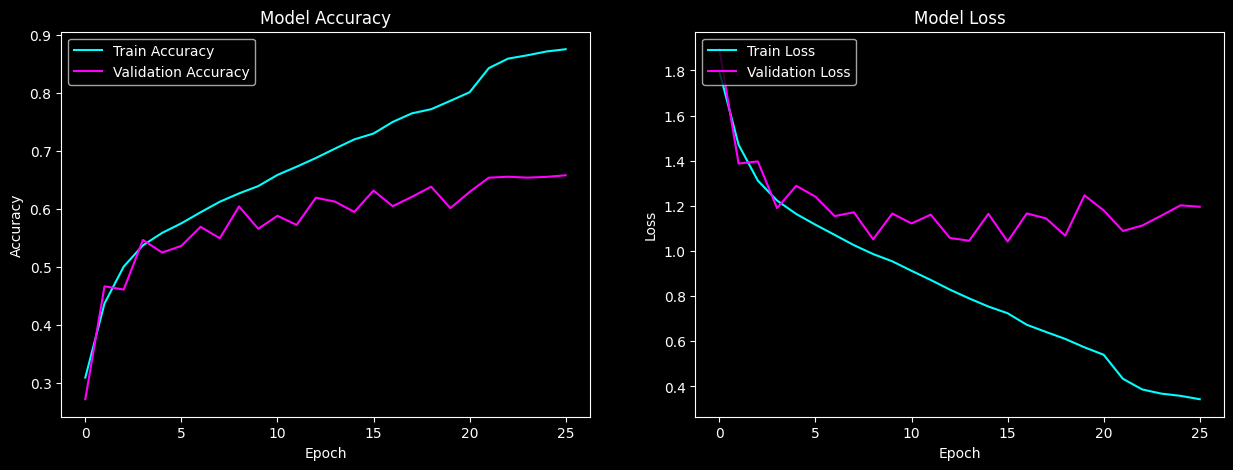


Test accuracy: 63.17%
Test loss: 1.0422
225/225 ━━━━━━━━━━━━━━━━━━━━ 3s 9ms/step

Classification Report:
              precision    recall  f1-score   support

       Angry       0.60      0.50      0.55       958
     Disgust       0.64      0.59      0.61       111
        Fear       0.54      0.41      0.46      1024
       Happy       0.84      0.82      0.83      1774
         Sad       0.46      0.58      0.51      1247
    Surprise       0.79      0.76      0.77       831
     Neutral       0.55      0.62      0.58      1233

    accuracy                           0.63      7178
   macro avg       0.63      0.61      0.62      7178
weighted avg       0.64      0.63      0.63      7178



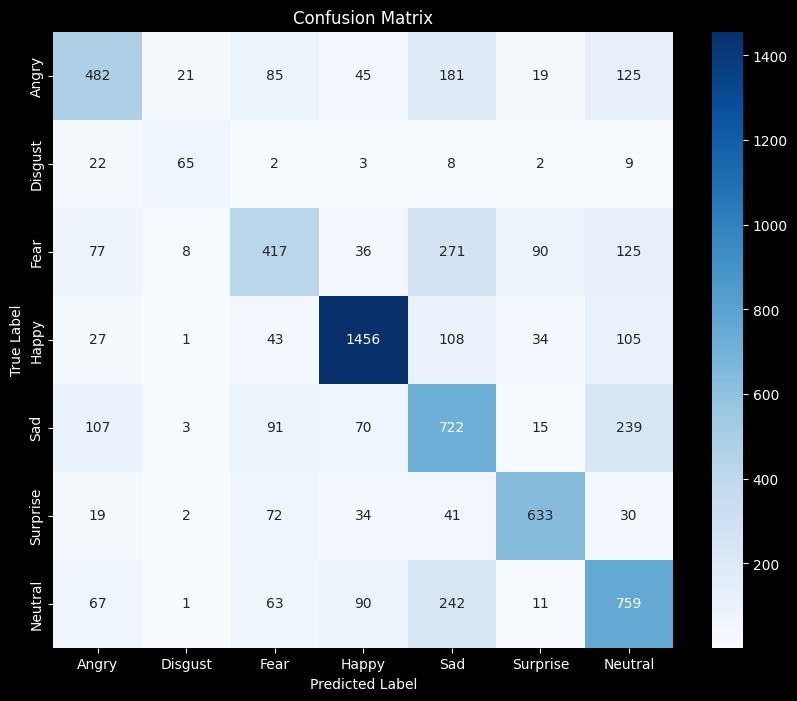

In [1]:
import os
import sys
import cv2
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

# --- Colab Setup (Run these cells first if using Google Colab) ---
def setup_kaggle_and_download():
    """Sets up Kaggle API and downloads the FER-2013 dataset."""
    # Check if running in Colab
    if 'google.colab' not in sys.modules:
        print("Not running in Colab. Skipping Kaggle setup.")
        return

    print("Setting up Kaggle API...")
    # Install the Kaggle library
    !pip install -q kaggle

    # Prompt user to upload their kaggle.json file
    from google.colab import files
    print("Please upload your 'kaggle.json' file from your computer.")
    uploaded = files.upload()

    # Check if the file was uploaded
    if "kaggle.json" not in uploaded:
        print("\n❌ Error: 'kaggle.json' not uploaded. Please run this cell again.")
        return

    # Move the kaggle.json file to the required directory and set permissions
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !chmod 600 ~/.kaggle/kaggle.json
    print("✅ Kaggle API configured successfully.")

    # Download the dataset
    print("\nDownloading FER-2013 dataset from Kaggle...")
    !kaggle datasets download -d msambare/fer2013 -p . --unzip
    print("✅ Dataset downloaded and unzipped successfully.")

    print("\n--- Current Directory Contents ---")
    !ls -l
    print("----------------------------------\n")

# --- 0. Environment Verification ---
def verify_environment():
    """Checks if all the required libraries are installed."""
    try:
        print("\nVerifying library installations...")
        # All necessary imports are at the top level now
        print("✅ All libraries are installed correctly.")
    except ImportError as e:
        print(f"❌ Error: A required library is missing: {e}")
        print("Please run 'pip install tensorflow opencv-python numpy matplotlib scikit-learn seaborn' in your activated virtual environment.")
        sys.exit(1)

from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense, BatchNormalization, Activation
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import EarlyStopping, ReduceLROnPlateau
from tensorflow.keras.utils import to_categorical

# --- 1. Load and Preprocess the Data from Image Folders ---
def load_and_preprocess_data_from_folders(dataset_path='.'):
    """
    Loads the FER-2013 dataset from a directory structure with train/test folders.

    Args:
        dataset_path (str): The path to the root directory containing train/test folders.

    Returns:
        A tuple containing (X_train, y_train, X_test, y_test).
    """
    emotion_mapping = {'angry': 0, 'disgust': 1, 'fear': 2, 'happy': 3, 'sad': 4, 'surprise': 5, 'neutral': 6}

    X_train, y_train = [], []
    X_test, y_test = [], []

    # Load training data
    train_path = os.path.join(dataset_path, 'train')
    for emotion_name, emotion_label in emotion_mapping.items():
        emotion_path = os.path.join(train_path, emotion_name)
        if not os.path.isdir(emotion_path): continue
        for img_name in os.listdir(emotion_path):
            img_path = os.path.join(emotion_path, img_name)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                X_train.append(image)
                y_train.append(emotion_label)

    # Load testing data
    test_path = os.path.join(dataset_path, 'test')
    for emotion_name, emotion_label in emotion_mapping.items():
        emotion_path = os.path.join(test_path, emotion_name)
        if not os.path.isdir(emotion_path): continue
        for img_name in os.listdir(emotion_path):
            img_path = os.path.join(emotion_path, img_name)
            image = cv2.imread(img_path, cv2.IMREAD_GRAYSCALE)
            if image is not None:
                X_test.append(image)
                y_test.append(emotion_label)

    # Convert lists to numpy arrays and preprocess
    X_train = np.array(X_train, dtype='float32') / 255.0
    X_test = np.array(X_test, dtype='float32') / 255.0

    X_train = np.expand_dims(X_train, -1)
    X_test = np.expand_dims(X_test, -1)

    y_train = to_categorical(np.array(y_train), num_classes=len(emotion_mapping))
    y_test = to_categorical(np.array(y_test), num_classes=len(emotion_mapping))

    print(f"Data loaded and preprocessed from folders.")
    print(f"Training samples: {len(X_train)}")
    print(f"Testing samples: {len(X_test)}")

    return X_train, y_train, X_test, y_test

# --- 2. Build the CNN Model ---
def build_model(input_shape=(48, 48, 1), num_classes=7):
    """
    Builds the CNN architecture for emotion detection.

    Args:
        input_shape (tuple): The shape of the input images.
        num_classes (int): The number of emotion classes to predict.

    Returns:
        A compiled Keras model.
    """
    model = Sequential()
    model.add(Conv2D(64, (3, 3), padding='same', input_shape=input_shape))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(128, (5, 5), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Conv2D(512, (3, 3), padding='same'))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(MaxPooling2D(pool_size=(2, 2)))
    model.add(Dropout(0.25))
    model.add(Flatten())
    model.add(Dense(256))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(512))
    model.add(BatchNormalization())
    model.add(Activation('relu'))
    model.add(Dropout(0.25))
    model.add(Dense(num_classes, activation='softmax'))

    optimizer = Adam(learning_rate=0.0005)
    model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

    print("Model built and compiled successfully.")
    model.summary()

    return model

# --- 3. Visualization and Evaluation Functions ---
def plot_training_history(history):
    """
    Plots the training and validation accuracy and loss.
    """
    plt.style.use('dark_background')
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 5))

    # Plot training & validation accuracy values
    ax1.plot(history.history['accuracy'], color='cyan', label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], color='magenta', label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_ylabel('Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.legend(loc='upper left')

    # Plot training & validation loss values
    ax2.plot(history.history['loss'], color='cyan', label='Train Loss')
    ax2.plot(history.history['val_loss'], color='magenta', label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_ylabel('Loss')
    ax2.set_xlabel('Epoch')
    ax2.legend(loc='upper left')

    plt.show()

def evaluate_model(model, X_test, y_test):
    """
    Evaluates the model on the test set and displays a confusion matrix
    and classification report.
    """
    # Evaluate the model on the test data
    loss, acc = model.evaluate(X_test, y_test, verbose=0)
    print(f"\nTest accuracy: {acc*100:.2f}%")
    print(f"Test loss: {loss:.4f}")

    # Generate predictions
    y_pred_probs = model.predict(X_test)
    y_pred = np.argmax(y_pred_probs, axis=1)
    y_true = np.argmax(y_test, axis=1)

    # Classification Report
    emotion_labels = ["Angry", "Disgust", "Fear", "Happy", "Sad", "Surprise", "Neutral"]
    print("\nClassification Report:")
    print(classification_report(y_true, y_pred, target_names=emotion_labels, zero_division=0))

    # Confusion Matrix
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(10, 8))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=emotion_labels, yticklabels=emotion_labels)
    plt.title('Confusion Matrix')
    plt.ylabel('True Label')
    plt.xlabel('Predicted Label')
    plt.show()


# --- Main Execution Block ---
if __name__ == "__main__":
    # Run setup for Kaggle if in Colab
    setup_kaggle_and_download()

    # Verify environment
    verify_environment()

    # Define constants
    DATASET_PATH = '.'
    MODEL_SAVE_PATH = 'emotion_model.h5'
    NUM_CLASSES = 7

    # Load data
    try:
        X_train, y_train, X_test, y_test = load_and_preprocess_data_from_folders(DATASET_PATH)
    except FileNotFoundError:
        print(f"Error: Dataset directory not found at {DATASET_PATH}")
        sys.exit(1)

    if len(X_train) == 0 or len(X_test) == 0:
        print("\n❌ Error: No training or testing data was loaded.")
        print("Please make sure you have run the Kaggle setup cell and uploaded your 'kaggle.json' file successfully.")
        sys.exit(1)

    # Build model
    model = build_model(input_shape=(48, 48, 1), num_classes=NUM_CLASSES)

    # Define callbacks
    early_stopping = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True, verbose=1)
    reduce_lr = ReduceLROnPlateau(monitor='val_loss', factor=0.2, patience=5, min_lr=0.00001, verbose=1)

    # Train the model
    print("\n--- Starting Model Training ---")
    history = model.fit(
        X_train, y_train,
        batch_size=64,
        epochs=100,
        validation_data=(X_test, y_test),
        callbacks=[early_stopping, reduce_lr]
    )

    # --- 4. Save and Evaluate ---
    print("\n--- Training Finished. Saving model... ---")
    model.save(MODEL_SAVE_PATH)
    print(f"Model saved successfully to {MODEL_SAVE_PATH}")

    # --- 5. Visualize and Evaluate the results ---
    print("\n--- Evaluating Model Performance ---")
    plot_training_history(history)
    evaluate_model(model, X_test, y_test)
